# Analyse et prévision de séries chronologiques
## Dans ce projet, nous allons faire une analyse exploratoire des données de plus de 900 magasins appartenant à une entreprise, choisir les 4 meilleurs magasins de chaque type et faire une prévision des ventes en fonction des jours fériés et des données historiques.



In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
from pandas import datetime


In [2]:
sns.set(rc={'figure.figsize':(16,9)} , font_scale=1.5 , style='whitegrid')
pd.set_option('display.max_columns', 30)

In [3]:
train = pd.read_csv('train.csv' , parse_dates=True)
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


##### Brève description:
- Sales: le chiffre d'affaires pour un jour donné (variable cible).
- Customers: le nombre des clients par jour.
- Open: indiquant si le magasin était ouvert: 0 = fermé, 1 = ouvert.
- Promo: indique si un magasin propose une promotion ce jour-là.
- StateHoliday: indique un jour férié. Normalement, tous les magasins, à quelques exceptions près, sont fermés les jours fériés.
- SchoolHoliday: indique si le (magasin, date) a été affecté par la fermeture des écoles publiques.

In [4]:
train['Date'] = pd.to_datetime(train['Date'])

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null datetime64[ns]
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


- nous n'avons pas de colonnes nulles
- maintenant nous devons définir des colonnes de date pour une analyse plus approfondie

In [6]:
train['Year'] = train['Date'].apply(lambda x: x.year)
train['Month'] = train['Date'].apply(lambda x: x.month)
train['Day'] = train['Date'].apply(lambda x: x.day)
train['DayOfWeek'] = train['Date'].apply(lambda x: x.dayofweek)
train['WeekOfYear'] = train['Date'].apply(lambda x: x.weekofyear)

In [7]:
dmap = { 0:'Lundi' , 1:'Mardi' , 2:'Mercredi' , 3:'Jeudi' , 4:'Vendredi' , 5:'Samedi' , 6:'Diamnche'}
train['DayOfWeek'] = train['DayOfWeek'].map(dmap)

In [8]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear
0,1,Vendredi,2015-07-31,5263,555,1,1,0,1,2015,7,31,31
1,2,Vendredi,2015-07-31,6064,625,1,1,0,1,2015,7,31,31
2,3,Vendredi,2015-07-31,8314,821,1,1,0,1,2015,7,31,31
3,4,Vendredi,2015-07-31,13995,1498,1,1,0,1,2015,7,31,31
4,5,Vendredi,2015-07-31,4822,559,1,1,0,1,2015,7,31,31


- maintenant nous créons une nouvelle colonne appelée "SalePerCustomer"(vente par client) en divisant les colonnes "Sales"(Ventes) sur "Customers"(clients)

In [9]:
train['SalePerCustomer'] = train['Sales'] / train['Customers']

In [10]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
0,1,Vendredi,2015-07-31,5263,555,1,1,0,1,2015,7,31,31,9.482883
1,2,Vendredi,2015-07-31,6064,625,1,1,0,1,2015,7,31,31,9.702400
2,3,Vendredi,2015-07-31,8314,821,1,1,0,1,2015,7,31,31,10.126675
3,4,Vendredi,2015-07-31,13995,1498,1,1,0,1,2015,7,31,31,9.342457
4,5,Vendredi,2015-07-31,4822,559,1,1,0,1,2015,7,31,31,8.626118


In [11]:
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

In [12]:
ss = train.groupby("Store")['SalePerCustomer'].describe()

- voici le top 5 des magasins triés par moyen de vente par client

In [13]:
ss.sort_values("mean"  , ascending=False).head()

,count,mean,std,min,25%,50%,75%,max
Store,,,,,,,,
842,622.0,16.064027,1.032046,13.334126,15.391947,16.000355,16.666855,19.573497
612,623.0,15.918960,1.459179,11.251479,14.913043,15.814917,16.928437,21.461652
455,777.0,15.758626,1.413862,11.004274,14.728929,15.715812,16.770563,19.695568
158,779.0,15.634011,1.289242,12.230047,14.686082,15.566075,16.517853,19.679417
868,781.0,14.616155,1.174607,11.175258,13.820339,14.621019,15.434326,18.632944


# le temps de voir la répartition des ventes, des clients et de la nouvelle colonne vente par client

In [14]:
col = ['Sales' , "Customers" , "SalePerCustomer" ]

In [15]:
train.fillna(0, inplace = True)

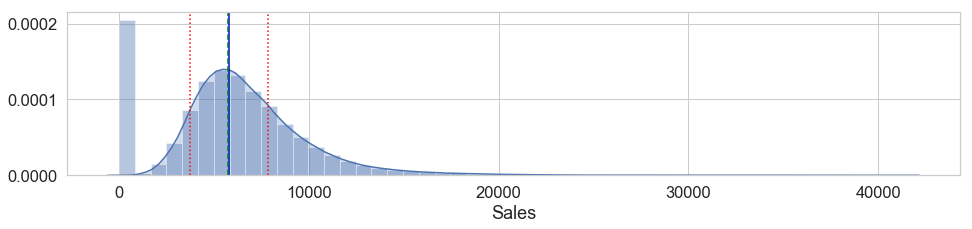

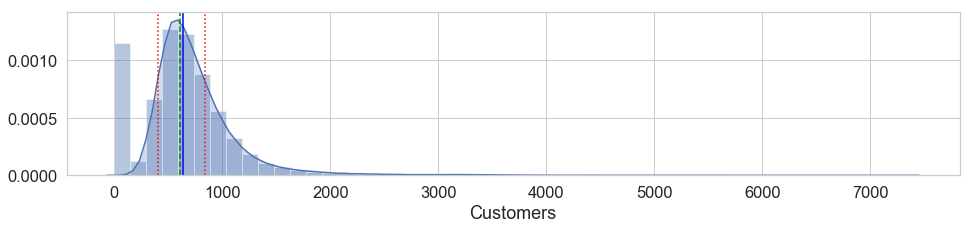

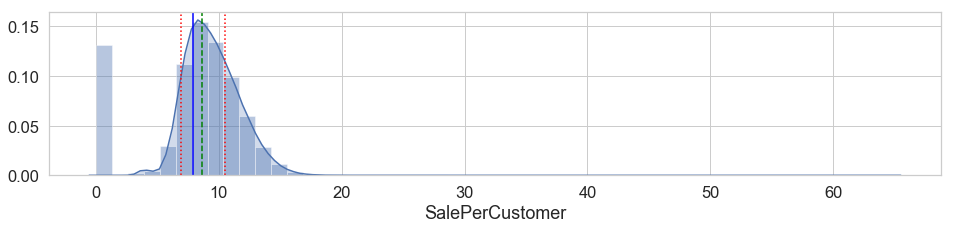

In [16]:
for i in col:
    plt.figure(figsize=(16,3))
    sns.distplot(train[i],kde_kws={"shade": True})
    plt.axvline(train[i].mean() , linestyle='-' , c="blue")
    plt.axvline(train[i].median() , linestyle='--' , c="green")
    plt.axvline(train[i].quantile(.25) , linestyle=':' , c="red")
    plt.axvline(train[i].quantile(.75) , linestyle=':' , c="red")
    plt.show()

- on peut voir que certaines données ont une valeur de 0, faisons la fonction de distribution cumulative pour l'analyse des caractéristiques

In [17]:
from statsmodels.distributions.empirical_distribution import ECDF

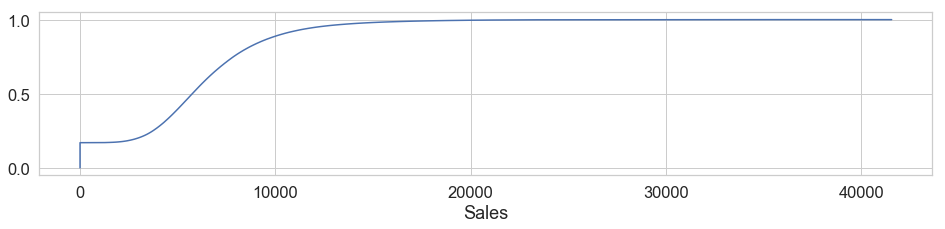

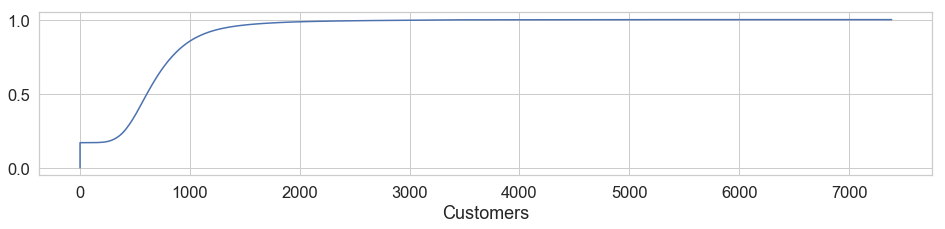

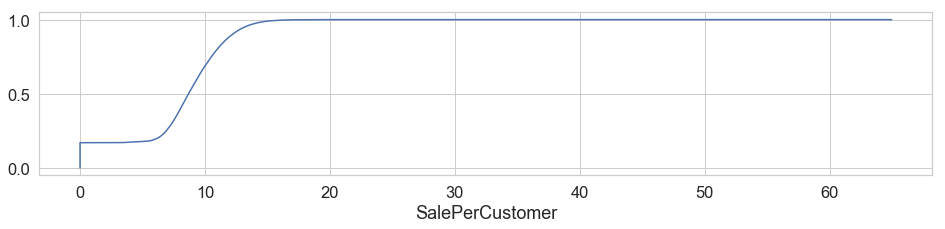

In [18]:
for i in col:
    ecdf = ECDF(train[i])
    plt.figure(figsize=(16,3))
    plt.plot(ecdf.x, ecdf.y,)
    plt.xlabel(i)
    plt.show()

- wa peut remarquer que près de 20% des données sont nulles, peut-être parce que certains magasins sont fermés en semaine ou en vacances

In [19]:
zero_close = train[(train.Open == 0) & (train.Sales == 0)]
print("In total : ", len(zero_close) , "times store was close , and of curse it had zero sales")

In total :  172817 times store was close , and of curse it had zero sales


In [20]:
zero_sales = train[(train.Open != 0) & (train.Sales == 0)]
print("In total : ", len(zero_sales) , "times store was open , and  had zero sales !!")

In total :  54 times store was open , and  had zero sales !!


- cette petite table indique le mois et le nombre de jours où les magasins étaient ouverts et n’avaient aucune vente

In [21]:
zero_sales.groupby('Month')['DayOfWeek'].count()

Month
1      8
2      4
3      5
4      5
5      4
6      5
7     11
8      2
9      9
10     1
Name: DayOfWeek, dtype: int64

In [22]:
print("Les magasins fermés et les jours sans ventes ne seront pas comptabilisés dans les prévisions.")
train = train[(train["Open"] != 0) & (train['Sales'] != 0)]

Les magasins fermés et les jours sans ventes ne seront pas comptabilisés dans les prévisions.


# informations supplémentaires sur les magasins

In [23]:
store = pd.read_csv('store.csv')
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


- Store: un identifiant unique pour chaque magasin
- StoreType: distingue 4 modèles de magasins différents: a, b, c, d
- Assortment: décrit un niveau d'assortiment: a = base, b = supplémentaire, c = étendue
- CompetitionDistance: distance en mètres du magasin concurrent le plus proche
- CompetitionOpenSince[Month/Year]: donne l'année et le mois approximatifs de l'ouverture du concurrent le plus proche
- Promo2: Promo2 est une promotion continue pour certains magasins: 0 = le magasin ne participe pas, 1 = le magasin participe
- Promo2Since[Year/Week]: décrit l'année et la semaine calendaire à laquelle le magasin a commencé à participer à Promo2
- PromoInterval: décrit les intervalles consécutifs auxquels Promo2 est démarré, en indiquant les mois de démarrage de la promotion. Par exemple. "Février, mai, août, novembre" signifie que chaque session commence en février, mai, août et novembre d'une année donnée pour ce magasin.

In [24]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [25]:
store[pd.isnull(store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [26]:
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

In [27]:
store.fillna(0, inplace = True)

# maintenant nous pouvons fusionner la première table avec la seconde table qui contient des informations de stockage 

In [28]:
train_store = pd.merge(train, store, how = 'inner', on = 'Store')
train_store.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,Vendredi,2015-07-31,5263,555,1,1,0,1,2015,7,31,31,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,Jeudi,2015-07-30,5020,546,1,1,0,1,2015,7,30,31,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,Mercredi,2015-07-29,4782,523,1,1,0,1,2015,7,29,31,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,Mardi,2015-07-28,5011,560,1,1,0,1,2015,7,28,31,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,Lundi,2015-07-27,6102,612,1,1,0,1,2015,7,27,31,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


## analyse statistique basée sur le type de magasin et les ventes
- il semble qu'il n'y ait pas beaucoup de magasins dans le type 'b' comparés à d'autres types (compte: 15560), mais la moyenne et la médiane du type 'b' sont presque le double de celles de l'autre type de magasin

In [29]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


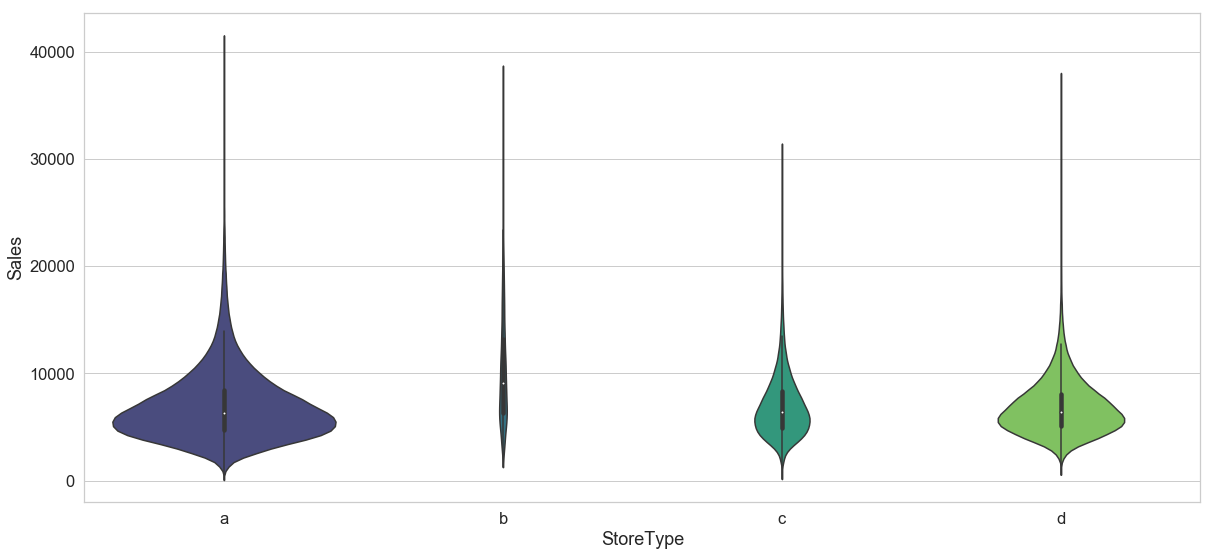

In [30]:
plt.figure(figsize=(20,9))
sns.violinplot(x='StoreType' , y='Sales' , data=train_store.sort_values('StoreType') , scale='count', cut=0 , palette='viridis')

## analyse statistique basée sur le type de magasin et les clients
- comme ci-dessus, le type 'b' a un faible nombre mais une moyenne et une médiane plus élevées

In [31]:
train_store.groupby('StoreType')['Customers'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,795.422370,387.516543,8.0,547.0,720.0,949.0,7388.0
b,15560.0,2022.211825,910.687095,219.0,1255.0,1839.5,2751.0,5494.0
c,112968.0,815.538073,329.670020,18.0,583.0,756.0,981.0,3096.0
d,258768.0,606.353935,199.247092,64.0,464.0,577.0,716.0,2239.0


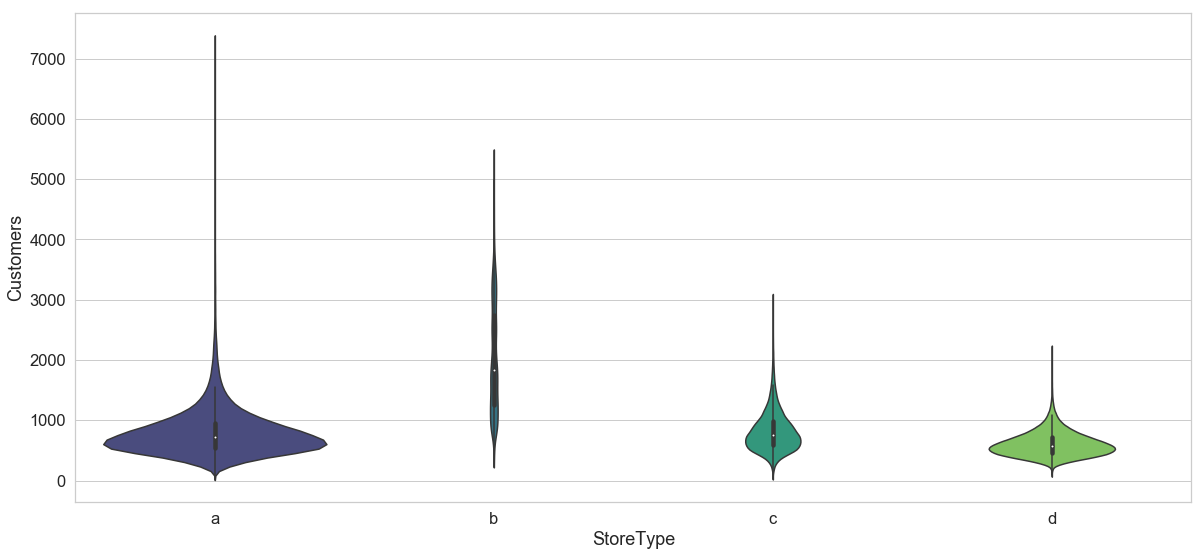

In [32]:
plt.figure(figsize=(20,9))
sns.violinplot(x='StoreType' , y='Customers' , data=train_store.sort_values('StoreType') ,
               scale='count' ,cut=0 , palette='viridis')

## analyse statistique basée sur le type de magasin et la vente par client
-type de magasin b ont un faible taux

In [33]:
train_store.groupby('StoreType')['SalePerCustomer'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,8.846296,1.690913,3.635389,7.611945,8.631363,9.899438,29.877551
b,15560.0,5.133427,1.253988,2.749075,4.039561,4.987022,6.108760,9.203528
c,112968.0,8.626227,1.694325,3.382542,7.416985,8.424736,9.643063,64.957854
d,258768.0,11.277862,1.990706,4.881279,9.873309,11.194977,12.560328,57.614983


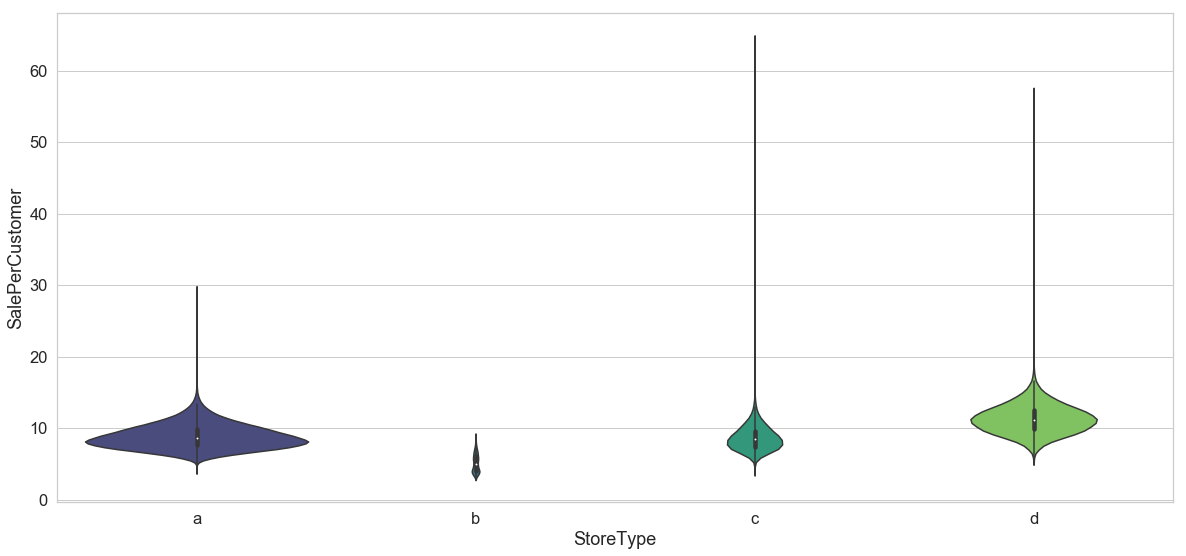

In [34]:
plt.figure(figsize=(20,9))
sns.violinplot(x='StoreType' , y='SalePerCustomer' , data=train_store.sort_values('StoreType') , cut=0 , scale='count' , palette='viridis')

In [35]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum()

,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


Il est clair que les magasins de types A et D occupent la deuxième place dans les ventes et les clients.


# Analyse des ventes

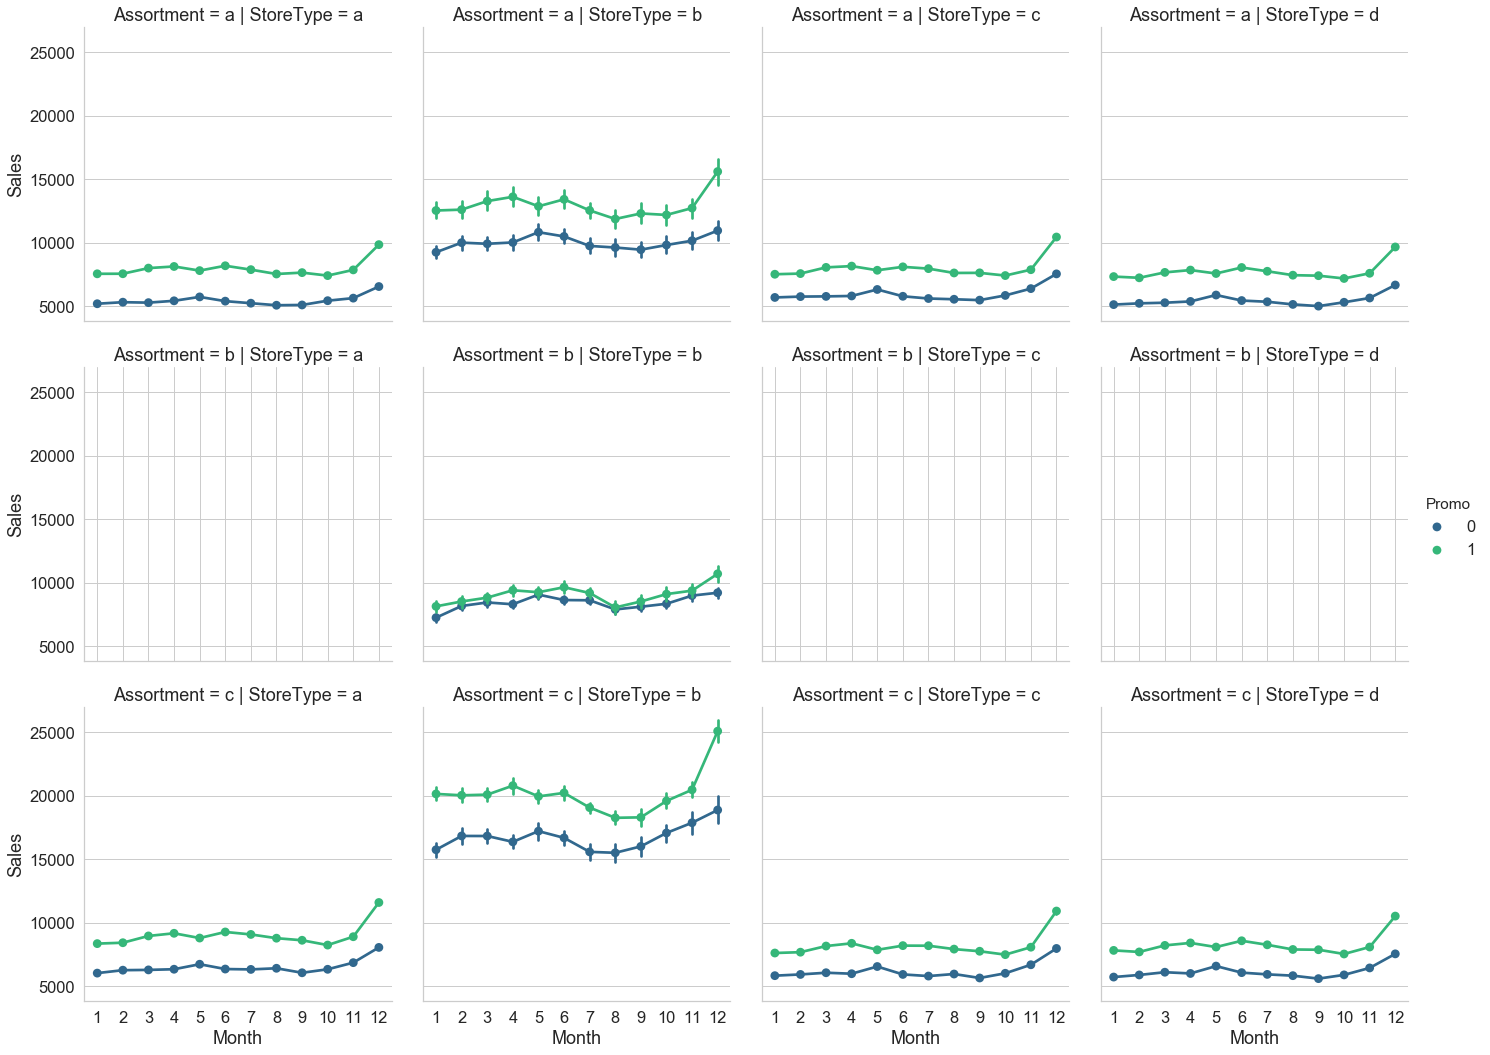

In [36]:
sns.catplot(data= train_store.sort_values(['Assortment','StoreType']) , x="Month" , y="Sales" , palette='viridis' ,
               col='StoreType', hue='Promo'  , row='Assortment' , kind='point')

# Analyse des clients

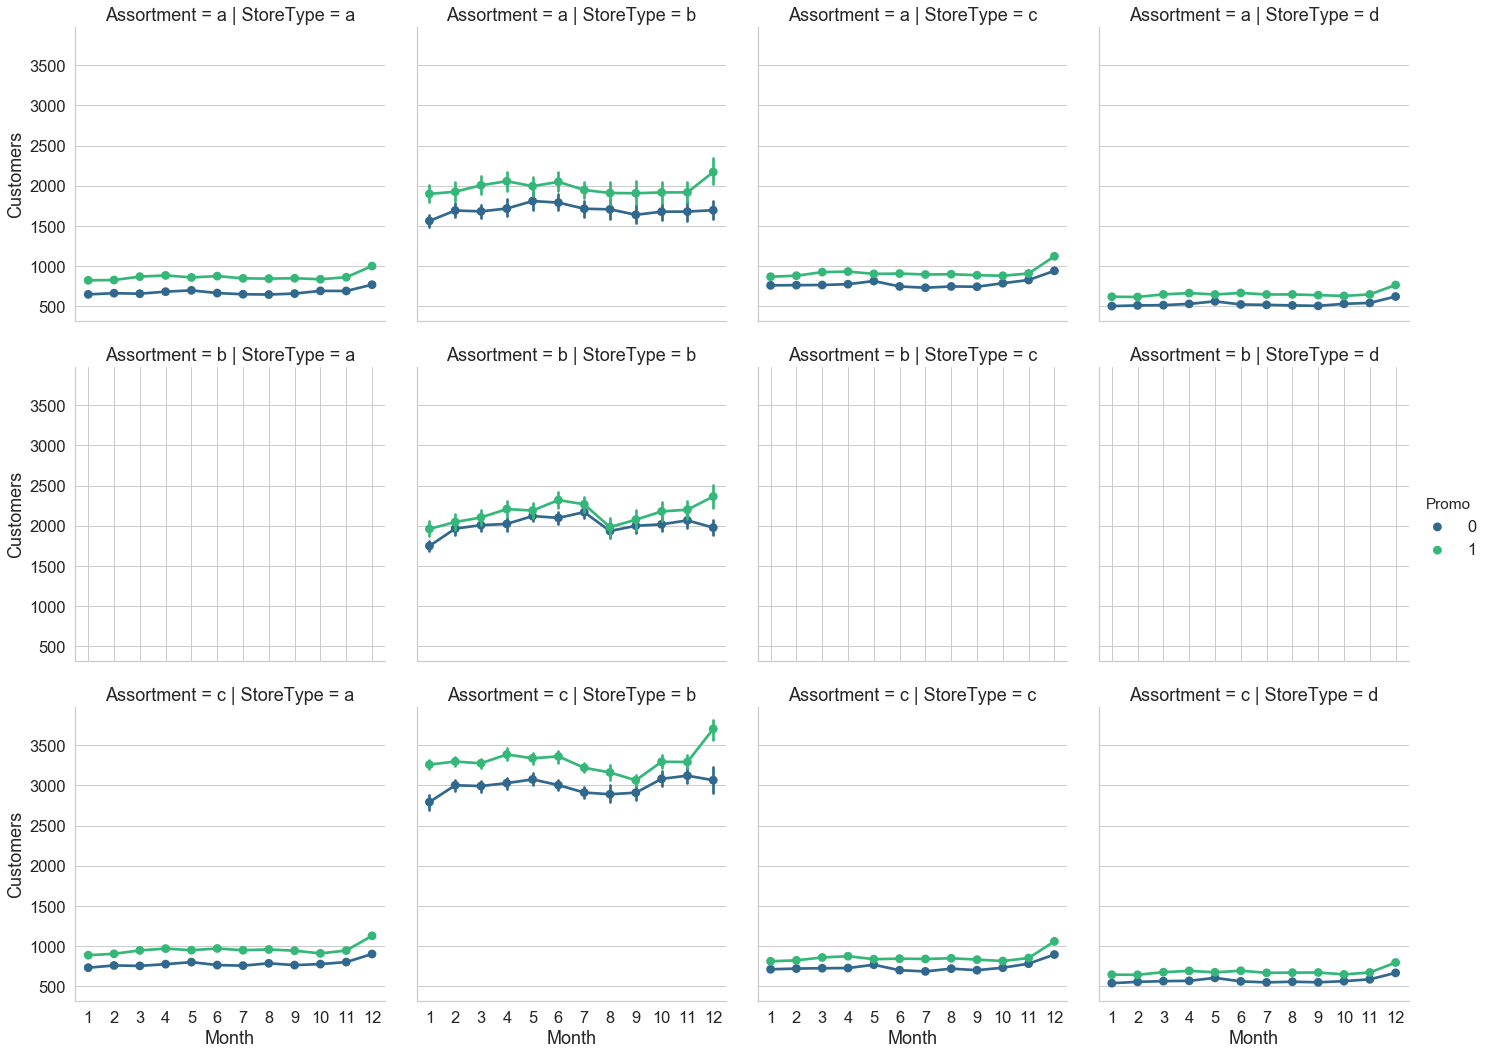

In [37]:
sns.catplot(data= train_store.sort_values(['Assortment','StoreType']) , x="Month" , y="Customers" , palette='viridis' ,
               col='StoreType', hue='Promo'  , row='Assortment', kind='point')

# et ventes par clients

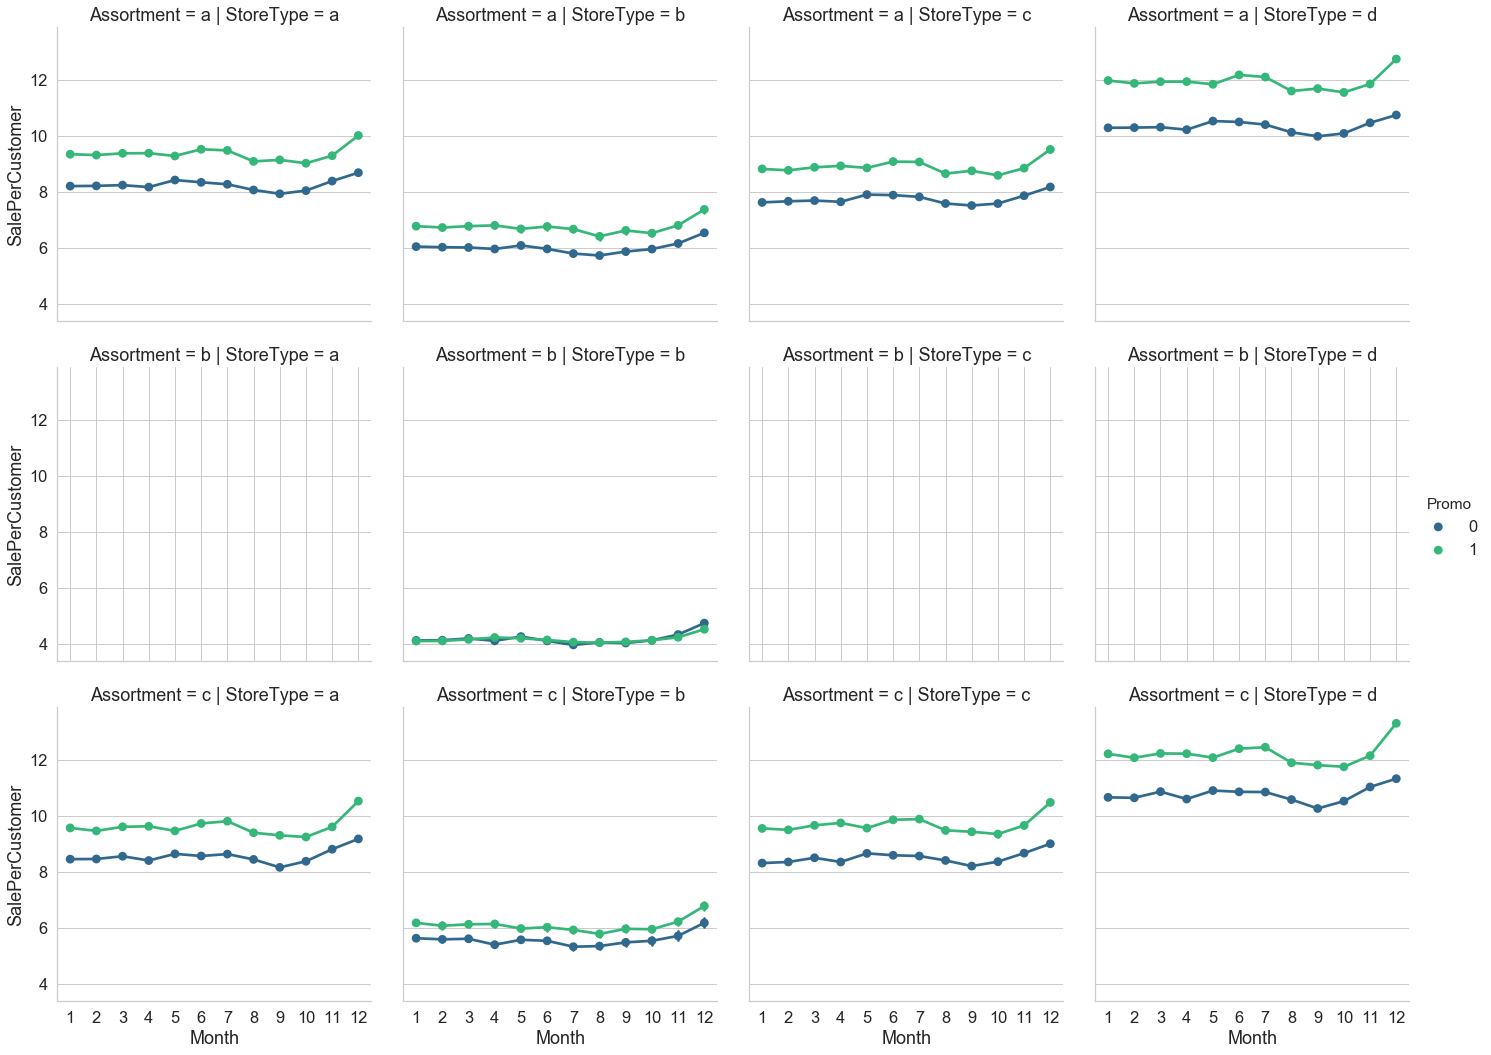

In [38]:
sns.catplot(data= train_store.sort_values(['Assortment','StoreType']) , x="Month" , y="SalePerCustomer" , palette='viridis' ,
               col='StoreType', hue='Promo'  , row='Assortment', kind='point')

Bien que les parcelles ci-dessus aient montré `StoreType` B comme le plus vendu et le plus performant, en réalité, ce n’est pas vrai. Le montant le plus élevé de `SalePerCustomer` est observé sur le` StoreType` D, environ 12 € avec `Promo` et 10 € sans promo. Quant à `StoreType` A et C, il est d'environ 9 €. 

# Analyse de corrélation

In [39]:
corr = train_store.drop('Open', axis = 1).corr()
corr

,Store,Sales,Customers,Promo,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
Store,1.000000,0.007723,0.033991,-0.000015,0.000526,0.000300,0.001371,-0.000127,0.001297,-0.048409,-0.027080,-0.032549,-0.008150,0.007728,0.010853,0.007760
Sales,0.007723,1.000000,0.823552,0.368199,0.038635,0.036151,0.073589,-0.051865,0.074463,0.186563,-0.035908,-0.018369,0.005257,-0.127556,-0.058493,-0.127581
Customers,0.033991,0.823552,1.000000,0.182859,0.024915,-0.000842,0.053843,-0.035416,0.053763,-0.323926,-0.147859,-0.021005,0.001657,-0.202207,-0.130864,-0.202180
Promo,-0.000015,0.368199,0.182859,1.000000,0.028971,0.023990,-0.006412,-0.126442,0.006947,0.280027,-0.002392,0.000710,0.000987,-0.000316,-0.000795,-0.000317
SchoolHoliday,0.000526,0.038635,0.024915,0.028971,1.000000,-0.038686,0.118467,0.038085,0.079584,0.013187,-0.004256,-0.000137,0.000118,-0.008244,-0.008069,-0.008247
Year,0.000300,0.036151,-0.000842,0.023990,-0.038686,1.000000,-0.268835,0.008387,-0.254433,0.072871,0.000632,-0.000546,-0.000174,-0.005696,-0.006905,-0.005697
Month,0.001371,0.073589,0.053843,-0.006412,0.118467,-0.268835,1.000000,-0.006577,0.960999,0.015371,0.003882,-0.001351,-0.000770,-0.025807,-0.031721,-0.025812
Day,-0.000127,-0.051865,-0.035416,-0.126442,0.038085,0.008387,-0.006577,1.000000,0.043696,-0.025104,-0.000227,-0.000200,-0.000323,0.001355,0.001450,0.001356
WeekOfYear,0.001297,0.074463,0.053763,0.006947,0.079584,-0.254433,0.960999,0.043696,1.000000,0.017432,0.003691,-0.001322,-0.000753,-0.024740,-0.030416,-0.024745
SalePerCustomer,-0.048409,0.186563,-0.323926,0.280027,0.013187,0.072871,0.015371,-0.025104,0.017432,1.000000,0.205720,-0.025779,-0.030562,0.215883,0.198835,0.215772


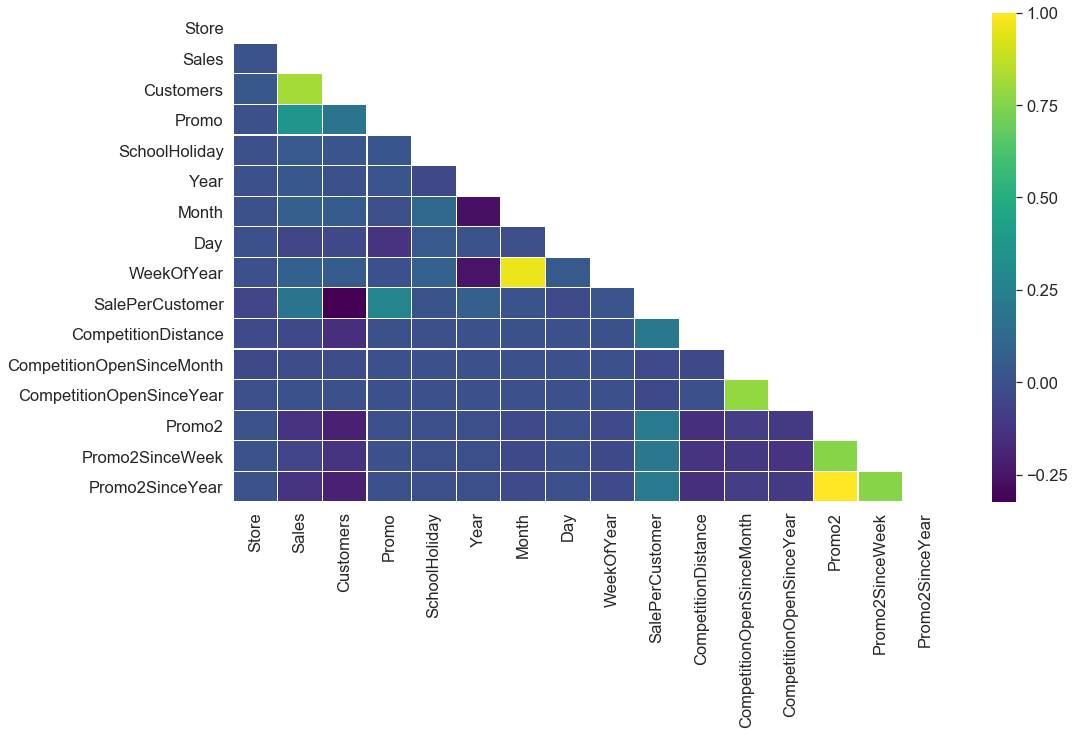

In [40]:
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr , cmap='viridis' ,linewidths = .1, mask=mask )

barre de corrélation pour Sales


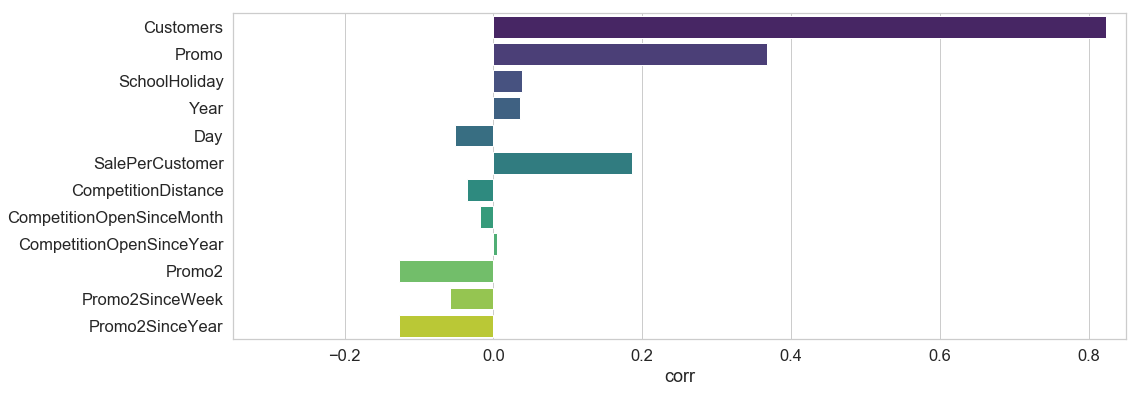

----------------------------
barre de corrélation pour Customers


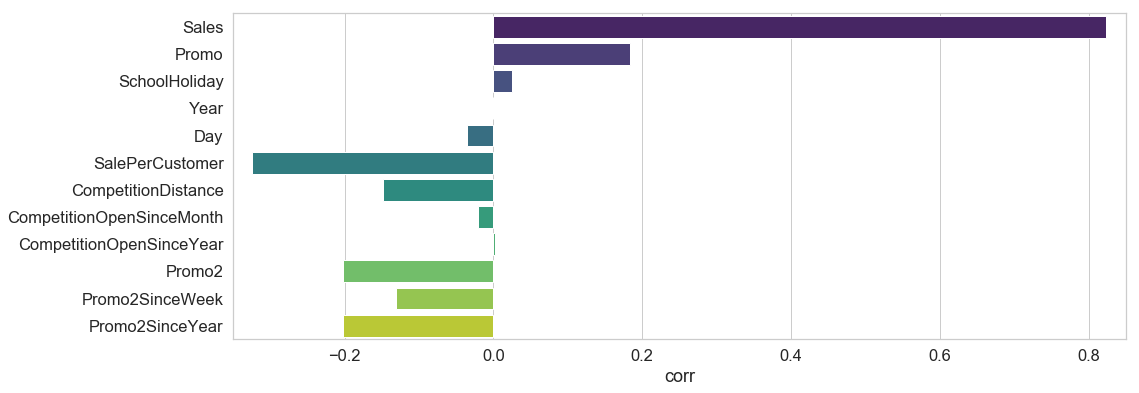

----------------------------
barre de corrélation pour SalePerCustomer


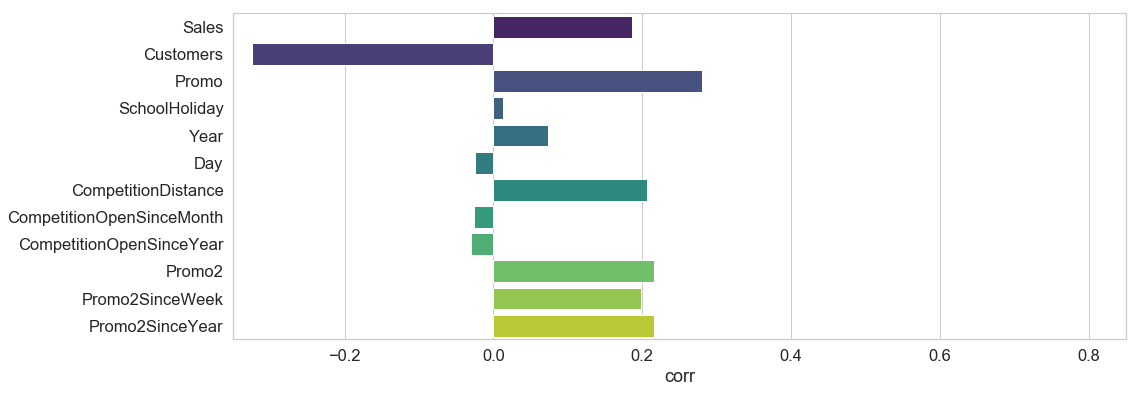

----------------------------


In [41]:
for i in ['Sales' , 'Customers' , 'SalePerCustomer'] :
    plt.figure(figsize=(16,6))
    plt.xlim((-0.35,0.85))
    ccc = (train_store.drop(columns=['Open' ,'Store' ,'Month','WeekOfYear', i]).corrwith(train_store[i]))
    ccc = pd.DataFrame(ccc , columns=['corr'])
    sns.barplot(y=ccc.index , x=ccc['corr'] , palette='viridis')
    print('barre de corrélation pour ' + i)
    plt.show()
    print('----------------------------')

- On ne voit pas que Promo est affecté par les ventes, plus on fait la promotion d'un magasin, plus on en a, mais ce n'est pas le cas avec Promo 2.
- mais Promo 2 augmentation Vente par client, cela signifie que si un magasin obtient Promo 2, les clients achèteront plus d'objet,

# analyse des magasins

In [42]:
for i in ["a" , "b" , "c" , "d"] : 
    st= train_store[train_store['StoreType'] ==i].groupby("Store")['Sales'].sum()
    print ("le magasin avec le plus de ventes et avoir le type " + i + " et le nombre de magasin est : " +  str(st.sort_values(ascending=False).index[0]))

le magasin avec le plus de ventes et avoir le type a et le nombre de magasin est : 817
le magasin avec le plus de ventes et avoir le type b et le nombre de magasin est : 262
le magasin avec le plus de ventes et avoir le type c et le nombre de magasin est : 523
le magasin avec le plus de ventes et avoir le type d et le nombre de magasin est : 842


Numéro de magasin 817 avec le type a


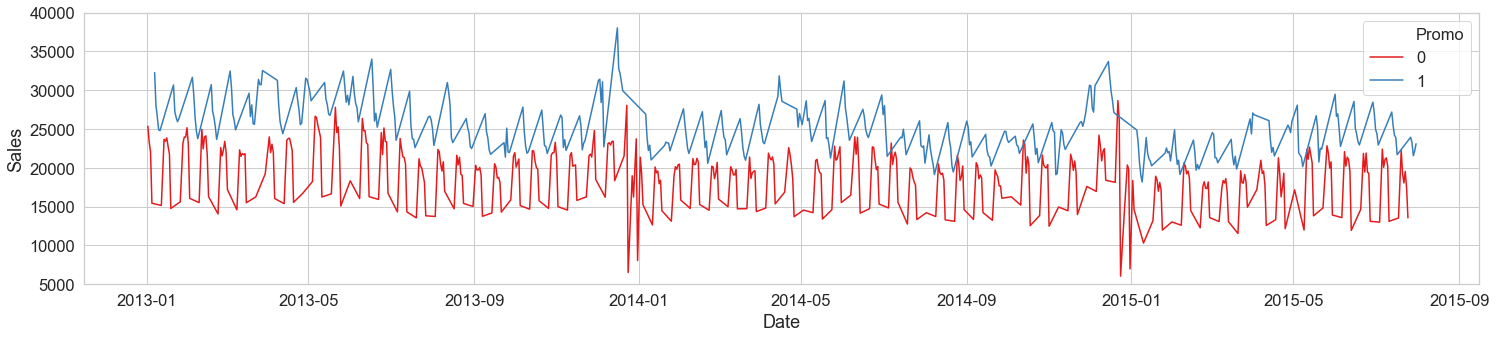

---------------
Numéro de magasin 262 avec le type b


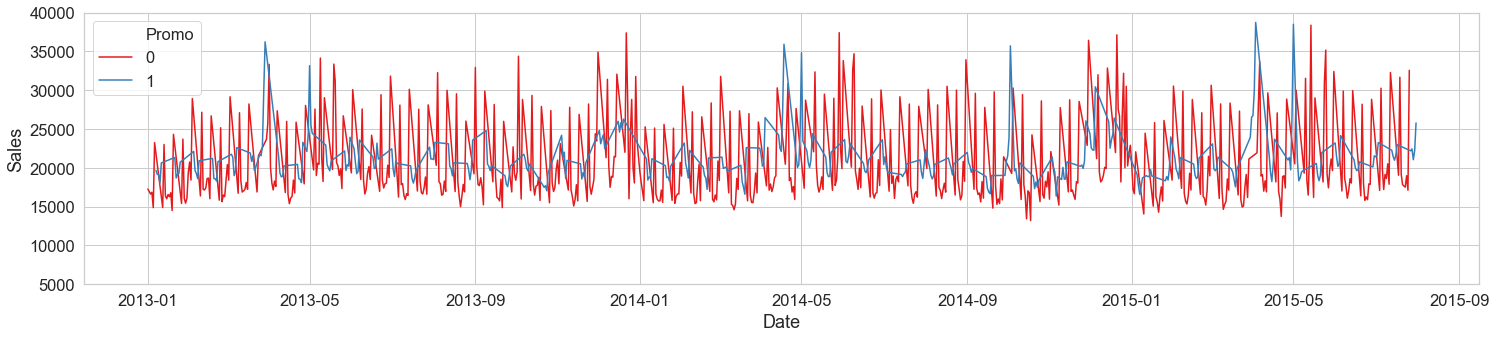

---------------
Numéro de magasin 523 avec le type c


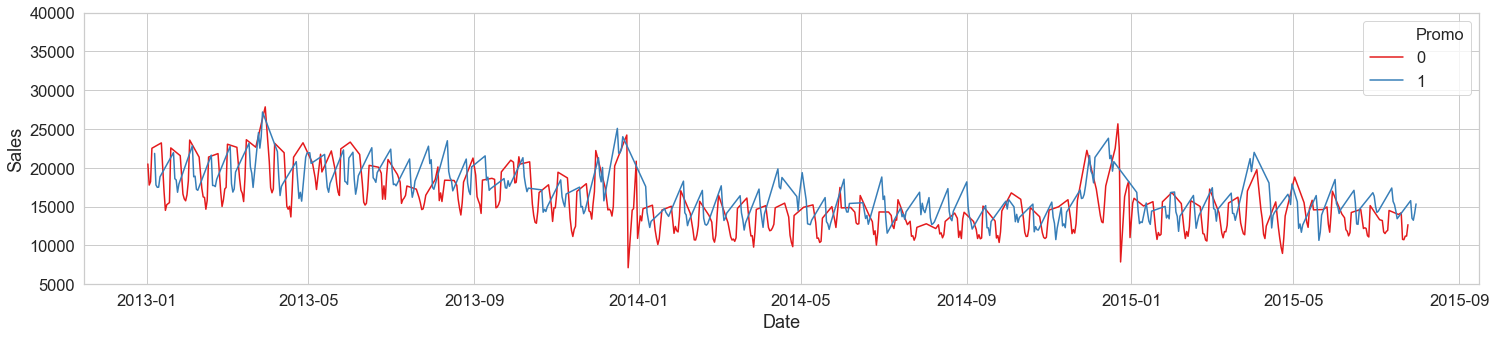

---------------
Numéro de magasin 842 avec le type d


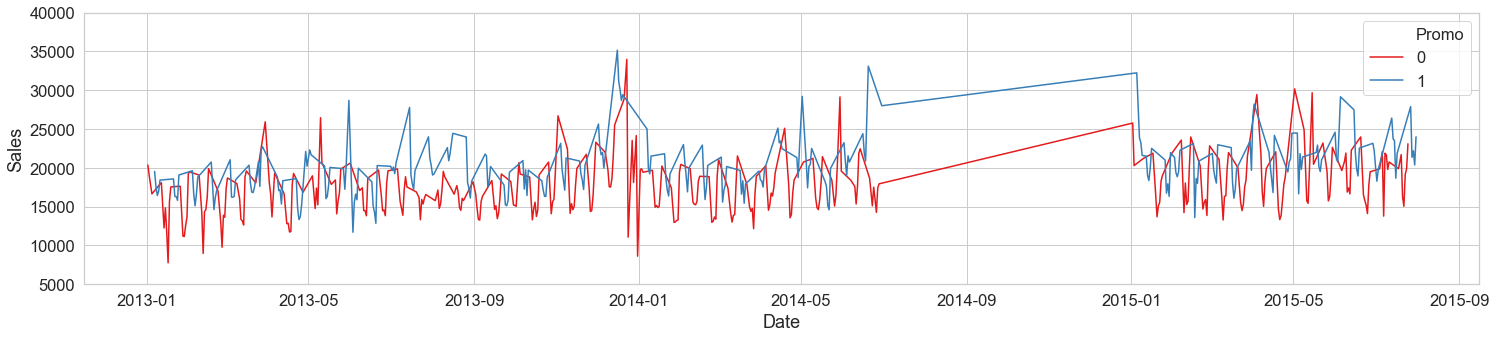

---------------


In [43]:
for i , c  in zip ([817 , 262 , 523 , 842],["a" , "b" , "c" , "d"]) :
    sales = train_store[train_store['Store']==i]
    plt.figure(figsize=(25,5))
    plt.ylim((5000 ,40000))
    sns.lineplot(x="Date" , y='Sales' , data=sales , hue="Promo" ,hue_order=[0,1], palette='Set1')
    print ("Numéro de magasin " + str(i) + " avec le type " + c )
    plt.show()
    print('---------------')
    

- Les ventes globales semblent augmenter, mais pas pour le type de magasin C. Bien que le type de magasin A soit le type de magasin le plus vendu dans les données, il semble qu'il puisse suivre la même trajectoire de réduction que le type de magasin C.

# Analyse et prévision de séries chronologiques
### Prévisions pour les 6 prochains mois
## the blue line represent the predicted value of sales ,
## red and green area are called confidence interval , 
## cela signifie que la valeur de vente prévue a de grandes chances d'être dans la ligne bleue, mais il y a une chance qu'elle soit bien en dessous ou au dessus

Numéro de magasin 817, type a prévisions pour 180 jours


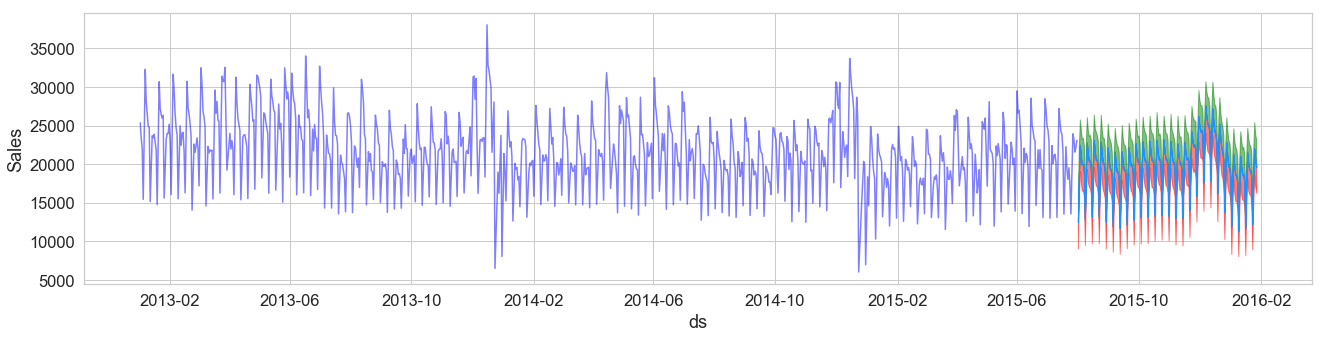

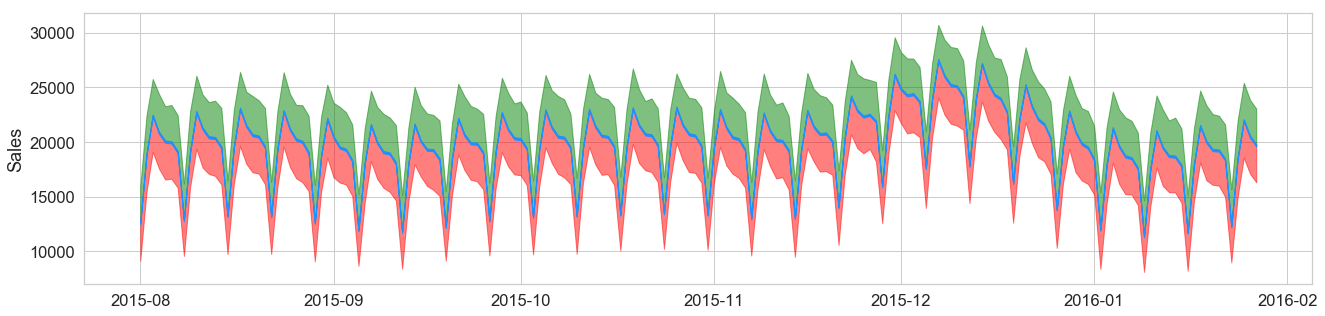

----------------

Numéro de magasin 262, type b prévisions pour 180 jours


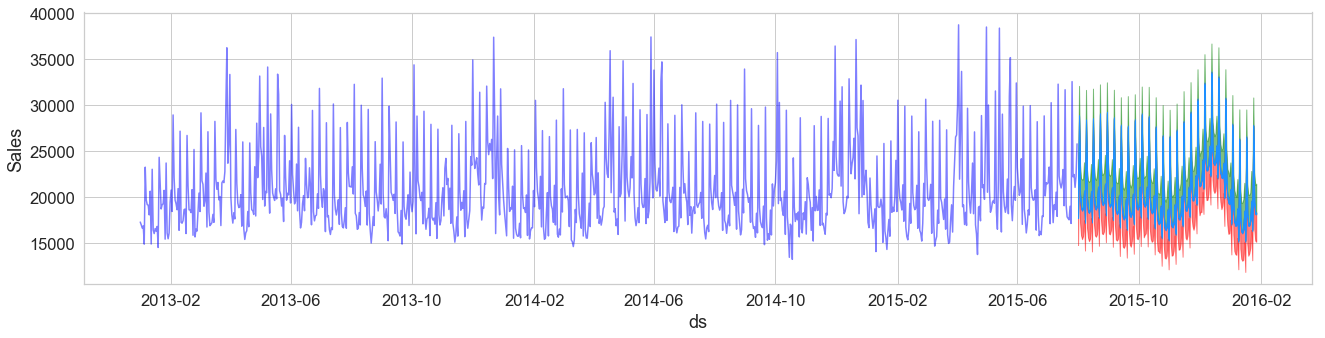

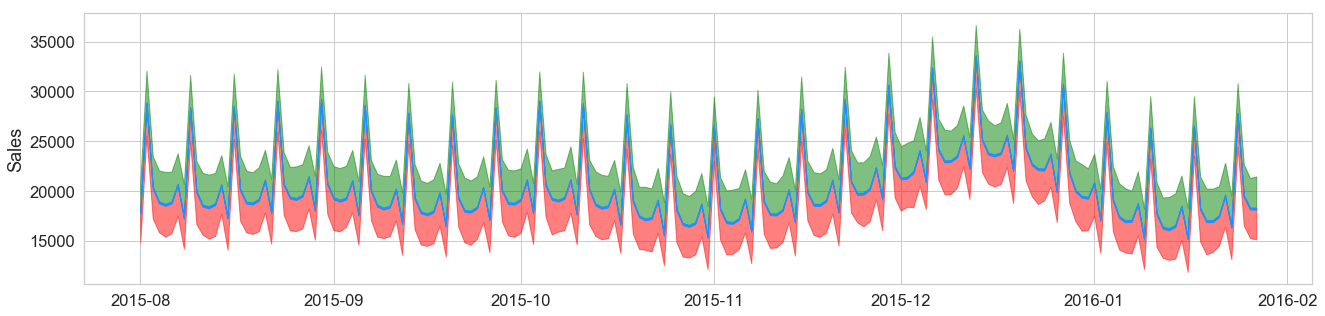

----------------

Numéro de magasin 523, type c prévisions pour 180 jours


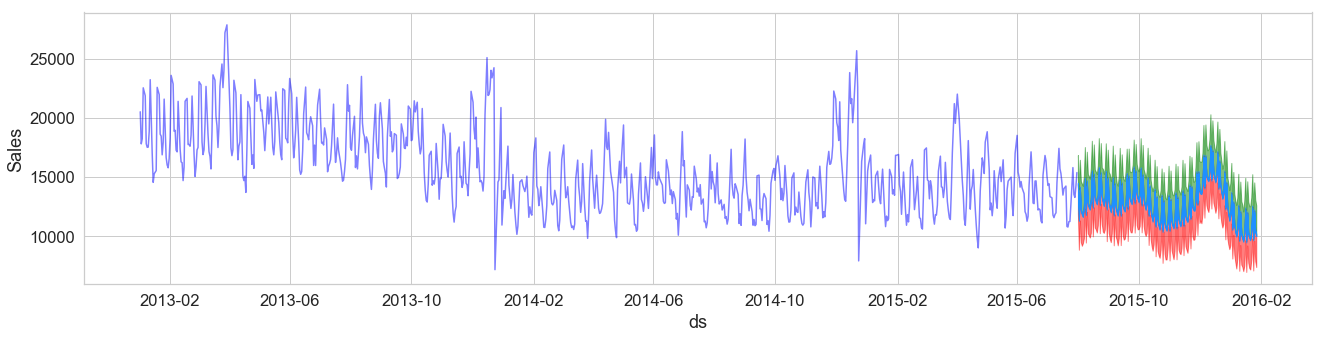

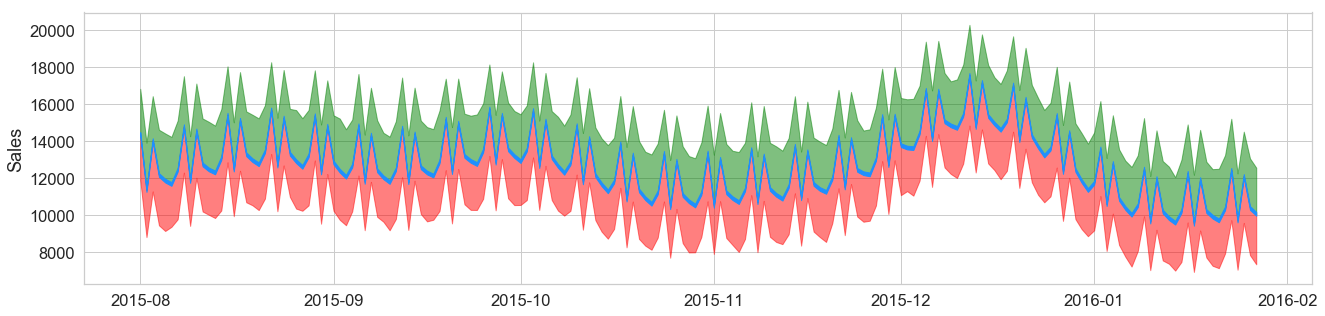

----------------

Numéro de magasin 842, type d prévisions pour 180 jours


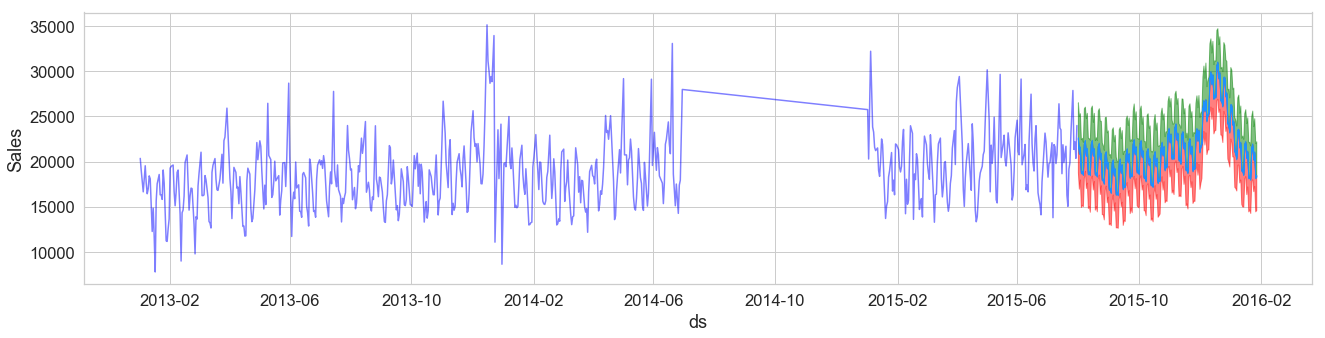

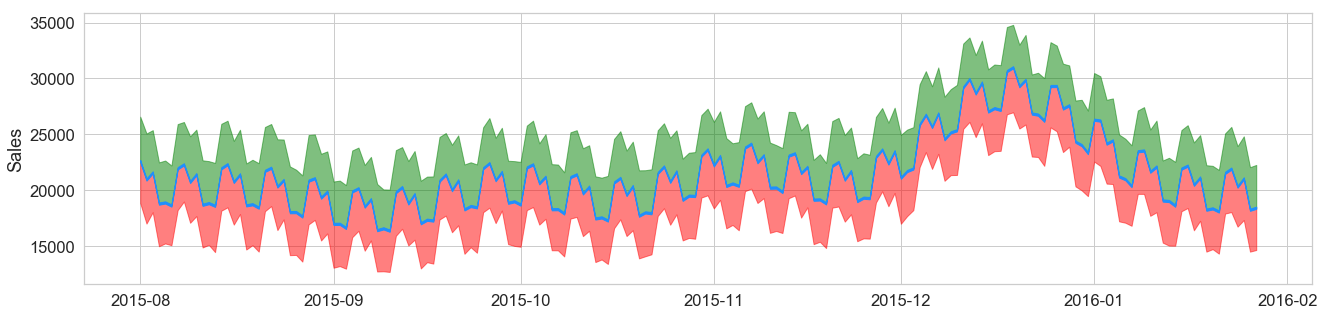

----------------



In [44]:
for i , c  in zip ([817 , 262 , 523 , 842],["a" , "b" , "c" , "d"]) :
    df = train_store[train_store["Store"] == i ]
    df= df[['Date' , 'Sales']]
    df = df.rename(columns={"Date":"ds" , "Sales":"y"})
    df = df.sort_values("ds")

    SchoolHoliday = train_store[(train_store["SchoolHoliday"]==1) & (train_store["Store"] == i) ]['Date'].values
    StateHoliday = train_store[(train_store.StateHoliday == 'a') | (train_store.StateHoliday == 'b')
                           | (train_store.StateHoliday == 'c') & (train_store["Store"] == i)].loc[:, 'Date'].values

    school = pd.DataFrame({"holiday":"School_Holiday" , "ds":pd.to_datetime(SchoolHoliday)})
    state = pd.DataFrame({"holiday":"State_Holiday" , "ds":pd.to_datetime(StateHoliday)})

    holidays = pd.concat([state , school])
    holidays = holidays.sort_values("ds")
    holidays = holidays.reset_index()
    holidays = holidays.drop_duplicates(subset="ds")

    m = Prophet( holidays=holidays , daily_seasonality=True , interval_width = 0.80 , seasonality_mode='multiplicative' )
    m.fit(df)

    future = m.make_future_dataframe(periods=180)
    forecast = m.predict(future)
    print ("Numéro de magasin " + str(i) + ", type " + c + " prévisions pour 180 jours" )
    plt.figure(figsize=(22 , 5))
    sns.lineplot(data=df , x='ds' , y='y' , color='blue' , alpha=0.5)
    plt.fill_between(x=forecast[forecast["ds"] > "2015-07-31"]["ds"].values,
                     y1=forecast[forecast["ds"] > "2015-07-31"]['yhat_upper'],
                     y2=forecast[forecast["ds"] > "2015-07-31"]['yhat'], alpha=0.5, color='green')
    plt.fill_between(x=forecast[forecast["ds"] > "2015-07-31"]["ds"].values,
                     y1=forecast[forecast["ds"] > "2015-07-31"]['yhat_lower'],
                     y2=forecast[forecast["ds"] > "2015-07-31"]['yhat'], alpha=0.5, color='red')
    plt.fill_between(x=forecast[forecast["ds"] > "2015-07-31"]["ds"].values,
                     y1=forecast[forecast["ds"] > "2015-07-31"]['yhat']-100,
                     y2=forecast[forecast["ds"] > "2015-07-31"]['yhat']+100, alpha=1, color='dodgerblue')
    plt.ylabel('Sales')

    plt.show()

    plt.figure(figsize=(22 , 5))
    plt.fill_between(x=forecast[forecast["ds"] > "2015-07-31"]["ds"].values,
                     y1=forecast[forecast["ds"] > "2015-07-31"]['yhat_upper'],
                     y2=forecast[forecast["ds"] > "2015-07-31"]['yhat'], alpha=0.5, color='green')
    plt.fill_between(x=forecast[forecast["ds"] > "2015-07-31"]["ds"].values,
                     y1=forecast[forecast["ds"] > "2015-07-31"]['yhat_lower'],
                     y2=forecast[forecast["ds"] > "2015-07-31"]['yhat'], alpha=0.5, color='red')
    plt.fill_between(x=forecast[forecast["ds"] > "2015-07-31"]["ds"].values,
                     y1=forecast[forecast["ds"] > "2015-07-31"]['yhat']-100,
                     y2=forecast[forecast["ds"] > "2015-07-31"]['yhat']+100, alpha=1, color='dodgerblue')
    plt.ylabel('Sales')

    plt.show()
    print ('----------------')
    print('')